#### Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
import re
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Nadam 
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### FaceLandmarks Data Processing for Autoencoder - (Using Raw FacePoints): ####

In [2]:
encoder_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Models/encoder_CNN.h5')

In [3]:
i = 0
n_samples_train = 5652
recordings = 1
target = []
features = []

for j in range(recordings):

  recording_n = str(j+1)
  features = np.load("/content/drive/MyDrive/Regressor/Capacitive_Data_Train/Capacitive_Train_Process("+ recording_n +").npy")
  i = 0
  for i in range(n_samples_train):

      img_number = str(i+1)
      img_path = "/content/drive/MyDrive/Regressor/Image_FaceShieldPoints_Train/Img_Record(" + recording_n + ")/Img_Train" + img_number + ".png"
      a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
      a = a[..., np.newaxis]
      target.append(a)

  target = np.asarray(target)
  target = target/255.

  # If it is the first generation of time features.
  if (j == 0):
      total_features = features
      total_targets = target
  # If it is not the first generation of time features.
  else:
      total_features = np.concatenate((total_features, features), axis=0)
      total_targets = np.concatenate((total_targets, target), axis=0)

print("-------------------- Total Images --------------------")
print("Total size Feature Set:", total_features.shape)
print("Total size Target Set:", total_targets.shape)

print("-------------------- Total Encoded Targets --------------------")
encoded_target = encoder_CNN.predict(total_targets)
print("Total size TRAIN Set:", encoded_target.shape)

-------------------- Total Images --------------------
Total size Feature Set: (5652, 20, 8)
Total size Target Set: (5652, 256, 256, 1)
-------------------- Total Encoded Targets --------------------
Total size TRAIN Set: (5652, 30)


In [ ]:
total_features = total_features[0:1998]
features.shape

(5652, 20, 8)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 19, 32)            544       
                                                                 
 batch_normalization_8 (Batc  (None, 19, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 32)            2080      
                                                                 
 batch_normalization_9 (Batc  (None, 18, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 18, 32)            0         
                                                                 
 flatten_4 (Flatten)         (None, 576)              

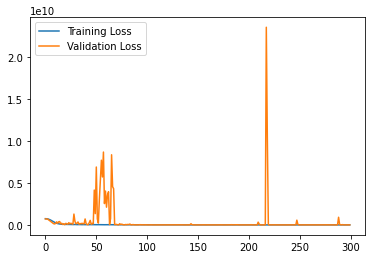

In [ ]:
#Prepare data for CNN model.
x_train = total_features
#n_output = enconded dimension.
n_output = encoded_target.shape[1]
y_train = encoded_target

#CNN:
# Parameters:
n_filters = 32
EPOCHS_CNN = 300

# Define architecture of CNN.
model_regresor = Sequential()
model_regresor.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_regresor.add(BatchNormalization())
model_regresor.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform"))
model_regresor.add(BatchNormalization())
model_regresor.add(Dropout(0.2))
model_regresor.add(Flatten())
model_regresor.add(Dense(50, activation='relu', kernel_initializer = "glorot_uniform"))
model_regresor.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_regresor.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_regresor.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_regresor.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=EPOCHS_CNN)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
model_regresor.save('/content/drive/MyDrive/Models/model_CNN_regresor.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           167200    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
Total params: 499,580
Trainable params: 499,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
142/142 [=============================

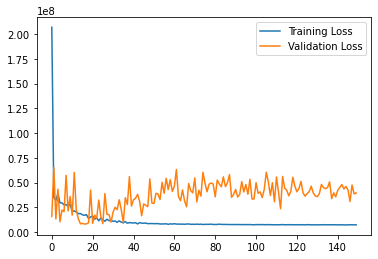

In [4]:
#Prepare data for CNN model.
x_train = total_features
#n_output = enconded dimension.
n_output = encoded_target.shape[1]
y_train = encoded_target

#CNN:
# Parameters:
n_filters = 32
EPOCHS_LSTM = 150

# Define architecture of CNN.
lstm_units_layer1 = 200
lstm_units_layer2= 200

# Define architecture of LSTM.
model_regresor_LSTM = Sequential()
model_regresor_LSTM.add(LSTM(lstm_units_layer1, activation='relu', return_sequences=True, kernel_initializer = "glorot_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_regresor_LSTM.add(LSTM(lstm_units_layer2, activation='relu', kernel_initializer = "glorot_uniform"))
model_regresor_LSTM.add(Dropout(0.2))
model_regresor_LSTM.add(Dense(50, activation='relu', kernel_initializer = "glorot_uniform"))
model_regresor_LSTM.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_regresor_LSTM.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_regresor_LSTM.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_regresor_LSTM.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=EPOCHS_LSTM)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [5]:
model_regresor_LSTM.save('/content/drive/MyDrive/Models/model_LSTM_regresor.h5')